<a href="https://colab.research.google.com/github/omerfcinoglu/Turkish_Sentiment_Analysis/blob/main/Turkish_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
import pickle

from datetime import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Definitions


In [30]:
train_data_path = "/content/drive/MyDrive/TSA-Dataset/train.csv"
test_data_path = "/content/drive/MyDrive/TSA-Dataset/test.csv"

label_map = {
    'Positive': 0,
    'Notr': 1,
    'Negative': 2
}

In [53]:
#tokenization
VOCAB_SIZE = 15000
MAX_LEN = 100
OOV_TOKEN = "<OOV>"

## FUNC DEF

In [ ]:
def turkish_lower(text):
    """
    Custom lowercasing function for Turkish characters.
    Standard Python .lower() converts 'I' to 'i', which is incorrect for Turkish.
    This function correctly converts 'I' -> 'ı' and 'İ' -> 'i'.
    """
    return str(text).replace('İ', 'i').replace('I', 'ı').lower()

def clean_text(text):
    """
    Performs text preprocessing:
    1. Lowercasing (Turkish compatible)
    2. Removing URLs
    3. Removing handles (@user) and hashtags (#tag)
    4. Removing punctuation and numbers
    5. Removing stopwords (excluding critical negation words)
    """
    # 1. Lowercase
    text = turkish_lower(text)

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove @mentions and #hashtags
    text = re.sub(r'\@\w+|\#\w+', '', text)

    # 4. Remove punctuation (keep only words and whitespace)
    text = re.sub(r'[^\w\s]', '', text)

    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 6. Remove Stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    return " ".join(filtered_words)

# EDA

In [5]:
df = pd.read_csv(train_data_path)
display(df.head())

,text,label,dataset
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,Positive,urun_yorumlari
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",Positive,urun_yorumlari
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",Positive,urun_yorumlari
3,Çünkü aranan tapınak bu bölgededir .,Notr,wiki
4,bu telefonu başlıca alma nedenlerim ise elimde...,Positive,urun_yorumlari


In [6]:
test_df = pd.read_csv(test_data_path)
display(test_df.head())

,text,label,dataset
0,Kral akbaba dikkat çekici renklere sahiptir .,Notr,wiki
1,ısrarla korkutmayı başarıyor. sanki korku çok...,Positive,HUMIR
2,Neşe ve Üzüntü köprünün kırılmaya başlamasıyla...,Notr,wiki
3,i phone 5 ten sonra gene 4'' ekranı tercih ett...,Positive,urun_yorumlari
4,Beşinci sezonda diziye yeni oyuncular katıldı .,Notr,wiki


In [10]:
num_rows = df.shape[0]
num_rows_test = test_df.shape[0]
print(f"The training dataset contains {num_rows} entries.")
print(f"The test dataset contains {num_rows_test} entries.")

The training dataset contains 440679 entries.
The test dataset contains 48965 entries.


In [16]:
label_counts = df['label'].value_counts()
label_counts_test = test_df['label'].value_counts()

label_counts_df = pd.DataFrame({
    'label': label_counts.index,
    'count': label_counts.values,
    'dataset': 'Train'
})

label_counts_test_df = pd.DataFrame({
    'label': label_counts_test.index,
    'count': label_counts_test.values,
    'dataset': 'Test'
})

combined_label_counts = pd.concat([label_counts_df, label_counts_test_df], ignore_index=True)

print("Combined Label Counts DataFrame:")
display(combined_label_counts)

Combined Label Counts DataFrame:


,label,count,dataset
0,Positive,235949,Train
1,Notr,153825,Train
2,Negative,50905,Train
3,Positive,26217,Test
4,Notr,17092,Test
5,Negative,5656,Test


In [14]:
df = pd.read_csv(train_data_path)

if 'Tweet' in df.columns:
    text_data = ' '.join(df['Tweet'].astype(str).tolist())
elif 'text' in df.columns:
    text_data = ' '.join(df['text'].astype(str).tolist())
else:
    print("Could not find a common text column like 'Tweet' or 'text'. Please specify the text column name.")
    text_data = "This is a sample text to generate a word cloud if no specific text column is found. Word cloud generation helps visualize word frequency in a corpus of text. Frequent words appear larger."

print(f"Length of combined text data: {len(text_data)} characters.")

Length of combined text data: 62187598 characters.


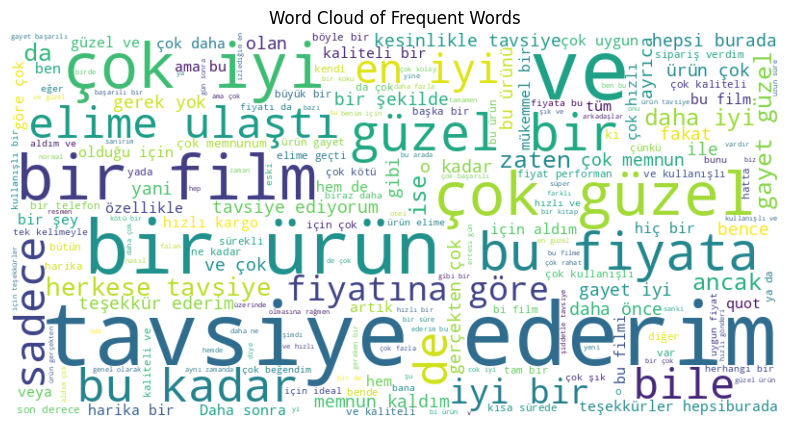

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Do not show axes
plt.title('Word Cloud of Frequent Words')
plt.show()

# Data Cleaning & Preprocessing


In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop_words = set(stopwords.words('turkish'))

critical_words = {'değil', 'yok', 'hayır', 'hiç', 'ama', 'fakat', 'lakin'}
stop_words = stop_words - critical_words

In [34]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

for df_name, df in [("Train", df_train), ("Test", df_test)]:
    print(f"Processing {df_name} dataset... (Rows: {len(df)})")

    # Drop unnecessary columns if they exist
    if 'dataset' in df.columns:
        df.drop('dataset', axis=1, inplace=True)

    # Label Encoding
    # Ensure labels are strings and strip whitespace
    df['label'] = df['label'].astype(str).str.strip()
    df['label_id'] = df['label'].map(label_map)

    # Apply Text Cleaning
    df['clean_text'] = df['text'].apply(clean_text)

Processing Train dataset... (Rows: 440679)
Processing Test dataset... (Rows: 48965)


In [35]:
# --- 4. SAVE PROCESSED DATA ---
# Save with '_processed' suffix to distinguish from raw data
train_save_path = train_data_path.replace('.csv', '_processed.csv')
test_save_path = test_data_path.replace('.csv', '_processed.csv')

df_train.to_csv(train_save_path, index=False)
df_test.to_csv(test_save_path, index=False)

print("-" * 30)
print("Preprocessing Completed!")
print(f"Processed Train data saved to: {train_save_path}")
print(f"Processed Test data saved to: {test_save_path}")

# Display first 5 rows of the processed train data for verification
print("\nSample Processed Data (Train):")
print(df_train[['clean_text', 'label_id']].head())

------------------------------
Preprocessing Completed!
Processed Train data saved to: /content/drive/MyDrive/TSA-Dataset/train_processed.csv
Processed Test data saved to: /content/drive/MyDrive/TSA-Dataset/test_processed.csv

Sample Processed Data (Train):
                                          clean_text  label_id
0  ürünü hepsiburadadan alalı hafta oldu orjinal ...         0
1  ürünlerden memnunum kesinlikle herkese tavsiye...         0
2         hızlı kargo temiz alışverişteşekkür ederim         0
3                          aranan tapınak bölgededir         1
4  telefonu başlıca alma nedenlerim elimdeki sams...         0


# Tokenization & Padding

In [39]:
train_path = '/content/drive/MyDrive/TSA-Dataset/train_processed.csv'
test_path = '/content/drive/MyDrive/TSA-Dataset/test_processed.csv'

df_train = pd.read_csv(train_path).astype({'clean_text': 'str'})
df_test = pd.read_csv(test_path).astype({'clean_text': 'str'})

In [40]:
X_train_text = df_train['clean_text'].values
Y_train = df_train['label_id'].values

X_test_text = df_test['clean_text'].values
Y_test = df_test['label_id'].values

print(f"Train Size: {len(X_train_text)}")
print(f"Test Size: {len(X_test_text)}")

Train Size: 440679
Test Size: 48965


In [45]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_text)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
tokenizer_path = f'/content/drive/MyDrive/TSA-Dataset/Tokenizers/tokenizer_{timestamp}.pickle'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer saved to {tokenizer_path}")

Tokenizer saved to /content/drive/MyDrive/TSA-Dataset/tokenizer_20251203_145253.pickle


In [46]:
# Convert text to sequences of integers
# Example: "bu film güzel" -> [5, 23, 8]
sequences_train = tokenizer.texts_to_sequences(X_train_text)
sequences_test = tokenizer.texts_to_sequences(X_test_text)

In [47]:
# padding='post' adds zeros at the end: [5, 23, 0, 0]
# truncating='post' cuts off from the end if too long
X_train_pad = pad_sequences(sequences_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post', truncating='post')

In [48]:
print(f"Shape of X_train: {X_train_pad.shape}")
print(f"Shape of X_test: {X_test_pad.shape}")

Shape of X_train: (440679, 100)
Shape of X_test: (48965, 100)


In [52]:
np.save('/content/drive/MyDrive/TSA-Dataset/NumpyFormat/X_train.npy', X_train_pad)
np.save('/content/drive/MyDrive/TSA-Dataset/NumpyFormat/Y_train.npy', Y_train)
np.save('/content/drive/MyDrive/TSA-Dataset/NumpyFormat/X_test.npy', X_test_pad)
np.save('/content/drive/MyDrive/TSA-Dataset/NumpyFormat/Y_test.npy', Y_test)